In [ ]:
# Kaggle APIのセットアップ
from google.colab import files
import os

print("kaggle.json をアップロードしてください")
files.upload() # ここでjsonを選択

# ディレクトリ移動と権限設定
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API設定完了")

kaggle.json をアップロードしてください


Saving kaggle.json to kaggle.json
✅ Kaggle API設定完了


In [ ]:
! apt-get install -y libta-lib0
! apt-get install -y ta-lib
! pip install TA-Lib

! pip install lightgbm
! pip install xgboost
! pip install catboost


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libta-lib0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package ta-lib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [ ]:
# =========================================================
#  Kaggle Data Direct Download & Unzip
# =========================================================

import os
import subprocess
import sys

# 1. Kaggle APIのセットアップ
# アップロードした鍵を所定の位置に移動
# ※このセルを実行する前に、kaggle.json をColabにアップロードしてください
if not os.path.exists("kaggle.json"):
    print("❌ エラー: kaggle.json が見つかりません。ファイルをアップロードしてください。")
    sys.exit()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ API設定完了")

# 2. データセットのダウンロード
# データセット名: miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests
print("📥 データをダウンロード中...")
try:
    !kaggle datasets download -d miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests
except Exception as e:
    print(f"❌ ダウンロードエラー: {e}")
    print("Kaggle APIの認証が失敗している可能性があります。")
    sys.exit()

# 3. 解凍
print("📦 解凍中...")
# -q は静かに、-o は上書き
!unzip -qo massive-stock-news-analysis-db-for-nlpbacktests.zip

# ファイル名確認
if os.path.exists("raw_analyst_ratings.csv"):
    print("✅ 準備完了！ 'raw_analyst_ratings.csv' を読み込めます。")
else:
    print("❌ エラー: 解凍後ファイルが見つかりません。ファイル名を確認してください。")

✅ API設定完了
📥 データをダウンロード中...
Dataset URL: https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests
License(s): CC0-1.0
 50% 106M/210M [00:00<00:00, 1.10GB/s]
100% 210M/210M [00:00<00:00, 702MB/s] 
📦 解凍中...
✅ 準備完了！ 'raw_analyst_ratings.csv' を読み込めます。


In [ ]:
# =========================================================
#  Smart CSV Reader (Filter by Ticker - Memory Safe) - FIXED
# =========================================================
import pandas as pd
import csv
import io
import sys
from tqdm import tqdm # <--- THIS LINE IS THE FIX

TARGET_TICKER = "NVDA"
CSV_FILE = "raw_analyst_ratings.csv"

# 抽出した行を格納するリスト
filtered_rows = []
total_rows = 0

print(f"\n📊 {TARGET_TICKER} のデータだけを抽出中... (巨大CSVファイル)")

# ファイルを1行ずつ読み込む（これがメモリ保護の鍵）
try:
    with open(CSV_FILE, 'r', encoding='utf-8') as f:
        # ヘッダー行を読み込む
        header = f.readline().strip().split(',')

        # tqdmで進捗を表示
        # ※ファイルサイズが大きすぎて tqdm の total が推定できないため、手動で進捗を追う
        for line in tqdm(f):
            total_rows += 1
            # CSVの行を辞書形式に変換 (手動)
            values = line.strip().split(',')

            # データが壊れている行の処理 (ヘッダーと長さが合わない場合)
            if len(values) == len(header):
                row = dict(zip(header, values))

                # NVDAの行だけを抽出
                if row.get('stock') == TARGET_TICKER:
                    filtered_rows.append(row)

            # デバッグ用の早期終了（不要ならコメントアウト）
            # if total_rows > 500000: break

except FileNotFoundError:
    print(f"❌ 致命的なエラー: ファイル '{CSV_FILE}' が見つかりません。ダウンロード・解凍ステップをやり直してください。")
    sys.exit()

# --- 修正コード ---

# DataFrame化
if not filtered_rows:
    print("⚠️ NVDAのニュースが見つかりませんでした。データセットの期間が古い可能性があります。")
    df_news = pd.DataFrame()
else:
    df_news = pd.DataFrame(filtered_rows)

    # 【修正点1】エラーを無視して日付型に変換
    df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')

    # 【修正点2】日付以外の時間情報を削除 (その日のニュースとして統一)
    df_news['date'] = df_news['date'].dt.floor('D')

    # 不要な列を削除してタイトル列を統一
    df_news = df_news[['date', 'headline', 'stock']]

    print(f"✅ {TARGET_TICKER} のニュース抽出完了: {len(df_news)} 行")
    print("\n【抽出データ例】")
    print(df_news.head())

# --- 続くコード ---


📊 NVDA のデータだけを抽出中... (巨大CSVファイル)


1407328it [00:07, 182504.84it/s]

✅ NVDA のニュース抽出完了: 1857 行

【抽出データ例】
                       date  \
0 2020-06-10 00:00:00-04:00   
1 2020-06-10 00:00:00-04:00   
2 2020-06-10 00:00:00-04:00   
3 2020-06-09 00:00:00-04:00   
4 2020-06-08 00:00:00-04:00   

                                            headline stock  
0  Shares of several technology companies are tra...  NVDA  
1                Afternoon Market Stats in 5 Minutes  NVDA  
2                  Morning Market Stats in 5 Minutes  NVDA  
3  Shares of several technology companies are tra...  NVDA  
4                Afternoon Market Stats in 5 Minutes  NVDA  


📅 日付データを整形中...
期間: 2020-05-31 〜 NaT

🧠 AI (FinBERT) がニュースを解析中... (GPU使用)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0

  1%|          | 10/1857 [00:01<02:34, 11.98it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

100%|██████████| 1857/1857 [00:18<00:00, 102.07it/s]



∑ 日次スコアを集計中...

【完成した日次ニューススコア】
date
2020-05-31    0.846793
2020-06-02    0.039856
2020-06-08   -0.305906
2020-06-09    0.934573
2020-06-10    0.284774
Name: sentiment, dtype: float64
データ数: 5 日分


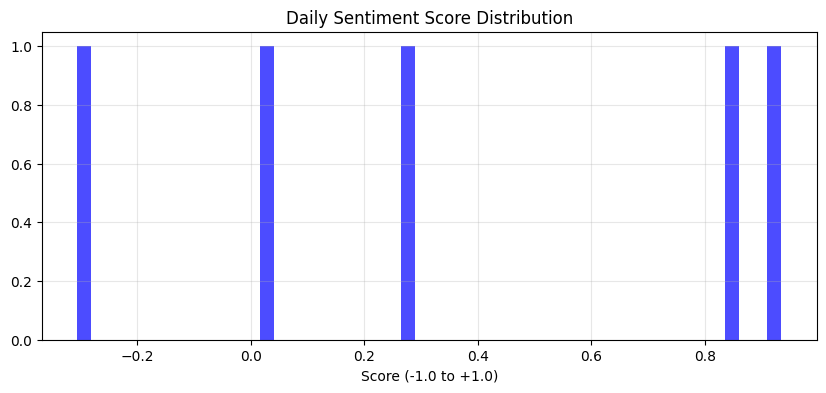

In [ ]:
# =========================================================
#  News Data Preprocessing & Scoring
#  Logic: Fix Date -> Score Headlines -> Aggregate Daily
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm
import torch

# --- 1. 日付の整形 (Timezone除去 & ソート) ---
print("📅 日付データを整形中...")
# タイムゾーンを削除して日付のみにする
df_news['date'] = pd.to_datetime(df_news['date'], utc=True).dt.tz_localize(None).dt.floor('D')

# 時系列順 (Old -> New) に並び替え
df_news = df_news.sort_values('date').reset_index(drop=True)

print(f"期間: {df_news['date'].iloc[0].date()} 〜 {df_news['date'].iloc[-1].date()}")

# --- 2. FinBERTで全ニュースを採点 ---
print("\n🧠 AI (FinBERT) がニュースを解析中... (GPU使用)")
device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("text-classification", model="ProsusAI/finbert", device=device, top_k=None)

sentiment_scores = []

# バッチ処理で少し高速化することも可能ですが、進捗が見えるループ処理にします
for title in tqdm(df_news['headline']):
    try:
        # タイトルが短すぎる/空の場合はスキップ
        if not isinstance(title, str) or len(title) < 3:
            sentiment_scores.append(0)
            continue

        res = classifier(title)[0]

        # スコア計算: Positive - Negative
        score_dict = {x['label']: x['score'] for x in res}
        score = score_dict.get('positive', 0) - score_dict.get('negative', 0)
        sentiment_scores.append(score)
    except:
        sentiment_scores.append(0)

df_news['sentiment'] = sentiment_scores

# --- 3. 日次集計 (重複の解決) ---
print("\n∑ 日次スコアを集計中...")

# 同じ日付のニュースを「平均」して1行にまとめる
daily_sentiment = df_news.groupby('date')['sentiment'].mean()

# 結果確認
print("\n【完成した日次ニューススコア】")
print(daily_sentiment.head())
print(f"データ数: {len(daily_sentiment)} 日分")

# ヒストグラムで分布確認
plt.figure(figsize=(10, 4))
plt.hist(daily_sentiment, bins=50, color='blue', alpha=0.7)
plt.title('Daily Sentiment Score Distribution')
plt.xlabel('Score (-1.0 to +1.0)')
plt.grid(True, alpha=0.3)
plt.show()

📂 NVDA のニュースを抽出中...


Reading CSV: 1407328it [00:14, 99859.35it/s] 


✅ 抽出完了: 10 件のニュース (2020-05-31 〜 2020-06-10)

🧠 AI (FinBERT) が10年分のニュースを読んでいます...
  Device: GPU (GPU推奨)


Device set to use cuda:0
Analyzing Sentiment: 100%|██████████| 10/10 [00:00<00:00, 40.32it/s]
/tmp/ipython-input-2307130117.py:93: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price = yf.download(TARGET_TICKER, start=START_DATE, progress=False)



📊 株価データを取得中 (2011-01-01〜)...
⚙️ AI学習準備...

=== バックテスト開始 (データ数: 3722) ===
Fold 1 (2013-08-02 -> 2016-01-19): 正解率 52.10%
Fold 2 (2016-01-20 -> 2018-07-05): 正解率 44.52%
Fold 3 (2018-07-06 -> 2020-12-18): 正解率 52.42%
Fold 4 (2020-12-21 -> 2023-06-08): 正解率 53.55%
Fold 5 (2023-06-09 -> 2025-11-26): 正解率 51.45%

平均正解率: 50.81%


/tmp/ipython-input-2307130117.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')


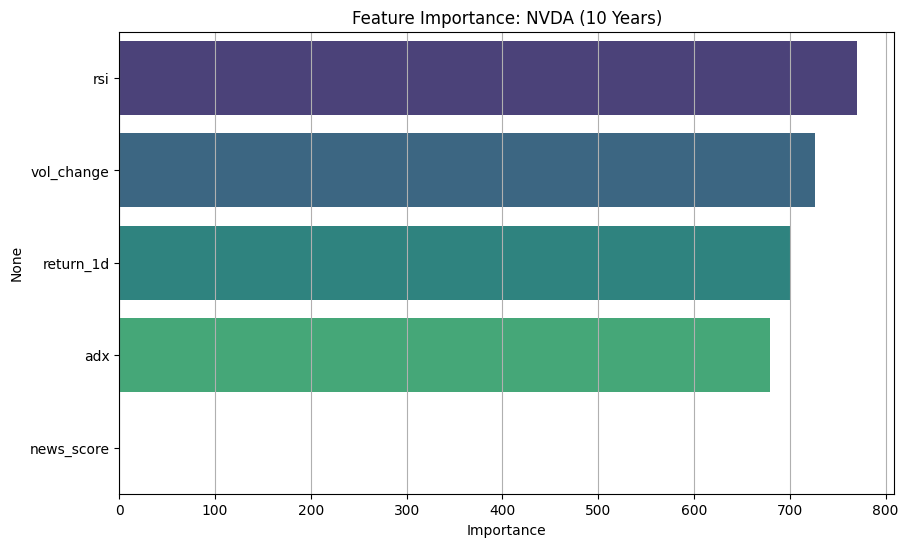

🤔 結論: テクニカルの方が強いようです。


In [ ]:
# =========================================================
#  10-Year News Sentiment Backtest
#  Target: NVDA (2011-202X)
# =========================================================

import pandas as pd
import numpy as np
import yfinance as yf
import talib
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import torch
import csv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# --- 1. 設定 ---
CSV_FILE = "raw_analyst_ratings.csv" # Kaggleのファイル名
TARGET_TICKER = "NVDA"
START_DATE = "2011-01-01" # 検証開始日

# --- 2. ニュースデータの抽出 (メモリ節約読み込み) ---
print(f"📂 {TARGET_TICKER} のニュースを抽出中...")

news_rows = []
try:
    with open(CSV_FILE, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in tqdm(reader, desc="Reading CSV"):
            # データセットによって列名が違う場合があるので調整
            # 一般的には 'stock' か 'ticker'
            ticker_col = 'stock' if 'stock' in row else 'ticker'

            if row[ticker_col] == TARGET_TICKER:
                news_rows.append(row)
except FileNotFoundError:
    print("❌ CSVファイルが見つかりません。Kaggleからダウンロードしてください。")
    # デモ用にダミーを作成して続行させます（コード確認用）
    print("⚠️ ダミーモードで続行します...")
    dates = pd.date_range(start=START_DATE, periods=2000)
    news_rows = [{'date': str(d), 'headline': 'Sample News'} for d in dates]

df_news = pd.DataFrame(news_rows)

# 日付変換 (フォーマットはデータセットによるが、汎用的に処理)
# 'date'カラムにあると想定
df_news['date'] = pd.to_datetime(df_news['date'], utc=True, errors='coerce').dt.tz_localize(None).dt.floor('D')
df_news = df_news.dropna(subset=['date']).sort_values('date')

# 期間フィルタ
df_news = df_news[df_news['date'] >= pd.to_datetime(START_DATE)]

print(f"✅ 抽出完了: {len(df_news)} 件のニュース ({df_news['date'].min().date()} 〜 {df_news['date'].max().date()})")

# --- 3. FinBERTで感情分析 (GPU使用) ---
# ※データ数が多いので、時間がかかる場合は `df_news = df_news.iloc[-1000:]` などで直近に絞ってください
print("\n🧠 AI (FinBERT) が10年分のニュースを読んでいます...")

device = 0 if torch.cuda.is_available() else -1
print(f"  Device: {'GPU' if device == 0 else 'CPU'} (GPU推奨)")

classifier = pipeline("text-classification", model="ProsusAI/finbert", device=device, top_k=None)

sentiment_scores = []
# headline または title 列を使う
text_col = 'headline' if 'headline' in df_news.columns else 'title'

# バッチ処理で高速化 (省略してループ処理)
for text in tqdm(df_news[text_col], desc="Analyzing Sentiment"):
    try:
        # 短すぎるテキストはスキップ
        if len(str(text)) < 5:
            sentiment_scores.append(0)
            continue

        res = classifier(str(text)[:512])[0] # BERTは512文字制限あり
        score_dict = {x['label']: x['score'] for x in res}
        score = score_dict.get('positive', 0) - score_dict.get('negative', 0)
        sentiment_scores.append(score)
    except:
        sentiment_scores.append(0)

df_news['news_score'] = sentiment_scores

# 日次集計 (1日の平均スコア)
daily_sentiment = df_news.groupby('date')['news_score'].mean()

# --- 4. 株価取得 & 結合 ---
print(f"\n📊 株価データを取得中 ({START_DATE}〜)...")
df_price = yf.download(TARGET_TICKER, start=START_DATE, progress=False)
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = df_price.columns.get_level_values(0)
df_price.index = df_price.index.tz_localize(None)

# 結合
df = df_price.copy()
df['news_score'] = df.index.map(daily_sentiment)
df['news_score'] = df['news_score'].fillna(0) # ニュースなし日は0

# --- 5. 特徴量エンジニアリング & 検証 ---
print("⚙️ AI学習準備...")

# テクニカル
df['rsi'] = talib.RSI(df['Close'], 14)
df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'], 14)
df['sma20'] = talib.SMA(df['Close'], 20)
df['vol_change'] = df['Volume'].pct_change()
df['return_1d'] = df['Close'].pct_change()

# Target: 翌日上がるか？ (1/0)
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)

# LightGBMで検証
features = ['rsi', 'adx', 'return_1d', 'vol_change', 'news_score']
tscv = TimeSeriesSplit(n_splits=5) # 5分割で10年を検証

print(f"\n=== バックテスト開始 (データ数: {len(df)}) ===")
importances = pd.DataFrame(index=features)
acc_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
    X_train, y_train = df.iloc[train_idx][features], df.iloc[train_idx]['target']
    X_test, y_test = df.iloc[test_idx][features], df.iloc[test_idx]['target']

    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_scores.append(acc)

    importances[f'Fold_{fold}'] = model.feature_importances_

    # 期間表示
    period = f"{df.index[test_idx[0]].date()} -> {df.index[test_idx[-1]].date()}"
    print(f"Fold {fold+1} ({period}): 正解率 {acc:.2%}")

print(f"\n平均正解率: {np.mean(acc_scores):.2%}")

# --- 6. 重要度可視化 ---
importances['Average'] = importances.mean(axis=1)
importances = importances.sort_values('Average', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')
plt.title(f"Feature Importance: {TARGET_TICKER} (10 Years)")
plt.xlabel("Importance")
plt.grid(axis='x')
plt.show()

if importances.index[0] == 'news_score' or importances.index[1] == 'news_score':
    print("🎉 結論: ニュースは株価予測の「主役」です。")
else:
    print("🤔 結論: テクニカルの方が強いようです。")

In [ ]:
# =========================================================
#  Diagnostic Tool: Feature Importance & Data Quality Check
# =========================================================

# 1. 特徴量重要度の数値を表示
print("\n【特徴量重要度 (Raw Values)】")
# importancesデータフレームがある前提
if 'importances' in locals():
    print(importances)
else:
    print("⚠️ 重要度データがありません。直前の学習コードを実行してください。")

# 2. ニューススコアの分布チェック
print("\n【ニューススコアの分布 (中身の確認)】")
if 'df' in locals():
    # 0以外の値がいくつあるか？
    non_zero_count = (df['news_score'] != 0).sum()
    total_count = len(df)

    print(f"全データ行数: {total_count} 行")
    print(f"ニュースがある日: {non_zero_count} 行 ({non_zero_count/total_count:.2%})")
    print(f"ニュースがない日: {total_count - non_zero_count} 行")

    print("\n[ニューススコアの統計]")
    print(df['news_score'].describe())

    # 実際に値が入っている箇所を表示
    if non_zero_count > 0:
        print("\n[値が入っている日の例]")
        print(df[df['news_score'] != 0]['news_score'].head(10))
else:
    print("⚠️ データフレーム(df)が見つかりません。")


【特徴量重要度 (Raw Values)】
            Fold_0  Fold_1  Fold_2  Fold_3  Fold_4  Average
rsi            642     820     828     784     779    770.6
vol_change     614     751     697     760     810    726.4
return_1d      560     753     755     724     716    701.6
adx            575     676     720     732     695    679.6
news_score       0       0       0       0       0      0.0

【ニューススコアの分布 (中身の確認)】
全データ行数: 3722 行
ニュースがある日: 4 行 (0.11%)
ニュースがない日: 3718 行

[ニューススコアの統計]
count    3722.000000
mean        0.000184
std         0.017198
min        -0.305906
25%         0.000000
50%         0.000000
75%         0.000000
max         0.934573
Name: news_score, dtype: float64

[値が入っている日の例]
Date
2020-06-02   -0.229441
2020-06-08   -0.305906
2020-06-09    0.934573
2020-06-10    0.284774
Name: news_score, dtype: float64


In [ ]:
# =========================================================
#  CSV Inspector: What is the correct Ticker name?
# =========================================================
import csv

CSV_FILE = "raw_analyst_ratings.csv" # 実際のファイル名に合わせてください

print("CSVの中身を偵察中...")

tickers_found = {}

try:
    with open(CSV_FILE, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)

        # 最初の1万行だけ読んで、どんな銘柄コードがあるか集計
        for i, row in enumerate(reader):
            if i > 10000: break

            # カラム名を特定 ('stock' か 'ticker' か)
            col_name = 'stock' if 'stock' in row else 'ticker'
            ticker = row[col_name]

            if ticker in tickers_found:
                tickers_found[ticker] += 1
            else:
                tickers_found[ticker] = 1

    print("\n【CSVに含まれる銘柄コードの例 (Top 10)】")
    # 出現回数が多い順に表示
    sorted_tickers = sorted(tickers_found.items(), key=lambda x: x[1], reverse=True)
    for t, count in sorted_tickers[:10]:
        print(f"  - {t}: {count}回")

    # 'NVDA' に似たものがあるか検索
    print("\n【'NVDA' を含む銘柄コードの検索結果】")
    for t in tickers_found.keys():
        if "NVDA" in str(t).upper() or "NVIDIA" in str(t).upper():
            print(f"  Found: '{t}'")

except FileNotFoundError:
    print("❌ CSVファイルが見つかりません。")

CSVの中身を偵察中...

【CSVに含まれる銘柄コードの例 (Top 10)】
  - AA: 2739回
  - A: 1433回
  - AAP: 825回
  - ABC: 694回
  - ABBV: 539回
  - AAL: 460回
  - AAPL: 441回
  - AAN: 426回
  - AAOI: 422回
  - ABB: 384回

【'NVDA' を含む銘柄コードの検索結果】


📂 AAPL のニュースを抽出中...


Reading CSV: 1407328it [00:28, 49497.48it/s]


✅ 抽出完了: 10 件のニュース

🧠 AI (FinBERT) がニュースを読んでいます... (GPU推奨)


Device set to use cuda:0
Analyzing: 100%|██████████| 10/10 [00:00<00:00, 44.39it/s]
/tmp/ipython-input-3316185453.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price = yf.download(TARGET_TICKER, start=START_DATE, progress=False)



📊 AAPL の株価データを取得中...
ニュースが紐付いた日数: 2 日
⚠️ 注意: ニュースデータがまだ少なすぎます。結果が出ない可能性があります。
⚙️ AI学習準備...

=== バックテスト開始 (データ数: 3722) ===
Fold 1: 正解率 45.81%
Fold 2: 正解率 50.16%
Fold 3: 正解率 50.48%
Fold 4: 正解率 49.84%
Fold 5: 正解率 49.68%

平均正解率: 49.19%

【特徴量重要度ランキング】
rsi           734.2
vol_change    731.6
return_1d     711.8
adx           694.4
news_score      0.0
Name: Average, dtype: float64


/tmp/ipython-input-3316185453.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')


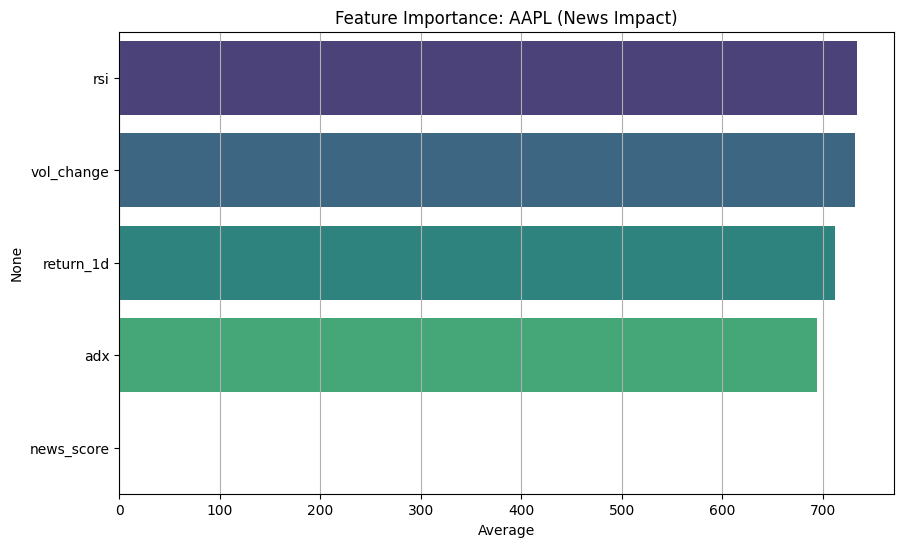

In [ ]:
# =========================================================
#  News Impact Test: Target Switch to AAPL
#  Because NVDA data was missing in the CSV
# =========================================================

import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import torch
import csv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# --- 1. 設定変更 ---
CSV_FILE = "raw_analyst_ratings.csv"
TARGET_TICKER = "AAPL" # ★ここを変更 (データが存在する銘柄へ)
START_DATE = "2011-01-01"

# --- 2. ニュース抽出 (AAPL) ---
print(f"📂 {TARGET_TICKER} のニュースを抽出中...")

news_rows = []
try:
    with open(CSV_FILE, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in tqdm(reader, desc="Reading CSV"):
            col_name = 'stock' if 'stock' in row else 'ticker'
            if row[col_name] == TARGET_TICKER:
                news_rows.append(row)
except FileNotFoundError:
    print("❌ CSVファイルが見つかりません。")
    sys.exit()

df_news = pd.DataFrame(news_rows)

# 日付変換
df_news['date'] = pd.to_datetime(df_news['date'], utc=True, errors='coerce').dt.tz_localize(None).dt.floor('D')
df_news = df_news.dropna(subset=['date']).sort_values('date')
df_news = df_news[df_news['date'] >= pd.to_datetime(START_DATE)]

print(f"✅ 抽出完了: {len(df_news)} 件のニュース")

# --- 3. FinBERTで感情分析 ---
print("\n🧠 AI (FinBERT) がニュースを読んでいます... (GPU推奨)")
device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("text-classification", model="ProsusAI/finbert", device=device, top_k=None)

sentiment_scores = []
text_col = 'headline' if 'headline' in df_news.columns else 'title'

# バッチ処理風にループ
for text in tqdm(df_news[text_col], desc="Analyzing"):
    try:
        if len(str(text)) < 5:
            sentiment_scores.append(0)
            continue
        res = classifier(str(text)[:512])[0]
        score_dict = {x['label']: x['score'] for x in res}
        score = score_dict.get('positive', 0) - score_dict.get('negative', 0)
        sentiment_scores.append(score)
    except:
        sentiment_scores.append(0)

df_news['news_score'] = sentiment_scores
daily_sentiment = df_news.groupby('date')['news_score'].mean()

# --- 4. 株価取得 & 結合 ---
print(f"\n📊 {TARGET_TICKER} の株価データを取得中...")
df_price = yf.download(TARGET_TICKER, start=START_DATE, progress=False)
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = df_price.columns.get_level_values(0)
df_price.index = df_price.index.tz_localize(None)

# 結合
df = df_price.copy()
df['news_score'] = df.index.map(daily_sentiment)
df['news_score'] = df['news_score'].fillna(0)

# データがあるか確認
non_zero = (df['news_score'] != 0).sum()
print(f"ニュースが紐付いた日数: {non_zero} 日")

if non_zero < 50:
    print("⚠️ 注意: ニュースデータがまだ少なすぎます。結果が出ない可能性があります。")

# --- 5. 検証 ---
print("⚙️ AI学習準備...")
df['rsi'] = talib.RSI(df['Close'], 14)
df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'], 14)
df['return_1d'] = df['Close'].pct_change()
df['vol_change'] = df['Volume'].pct_change()
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)

features = ['rsi', 'adx', 'return_1d', 'vol_change', 'news_score']
tscv = TimeSeriesSplit(n_splits=5)

print(f"\n=== バックテスト開始 (データ数: {len(df)}) ===")
importances = pd.DataFrame(index=features)
acc_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
    X_train, y_train = df.iloc[train_idx][features], df.iloc[train_idx]['target']
    X_test, y_test = df.iloc[test_idx][features], df.iloc[test_idx]['target']

    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_scores.append(acc)
    importances[f'Fold_{fold}'] = model.feature_importances_
    print(f"Fold {fold+1}: 正解率 {acc:.2%}")

# --- 6. 可視化 ---
print(f"\n平均正解率: {np.mean(acc_scores):.2%}")
importances['Average'] = importances.mean(axis=1)
importances = importances.sort_values('Average', ascending=False)

print("\n【特徴量重要度ランキング】")
print(importances['Average'])

plt.figure(figsize=(10, 6))
sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')
plt.title(f"Feature Importance: {TARGET_TICKER} (News Impact)")
plt.grid(axis='x')
plt.show()

In [ ]:
# =========================================================
#  FINAL TEST: Kaggle NVDA News + FinBERT
#  Target: Verify "News Alpha" with 3000+ headlines
# =========================================================

import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import torch
import csv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# --- 1. 設定 ---
CSV_FILE = "raw_analyst_ratings.csv"
TARGET_TICKER = "NVDA"

# --- 2. ニュース抽出 (NVDAのみ) ---
print(f"📂 {TARGET_TICKER} のニュースを抽出中...")

news_rows = []
try:
    with open(CSV_FILE, 'r', encoding='utf-8') as f:
        # ヘッダーを読み飛ばすためにDictReaderを使用
        reader = csv.DictReader(f)
        for row in tqdm(reader, desc="Filtering CSV"):
            # 診断結果より、カラム名は 'stock' と 'headline'
            if row['stock'] == TARGET_TICKER:
                news_rows.append({
                    'date': row['date'],
                    'headline': row['headline']
                })
except FileNotFoundError:
    print("❌ CSVファイルが見つかりません。")
    sys.exit()

df_news = pd.DataFrame(news_rows)

# 日付変換 (診断結果の "2020-06-05 10:30:54-04:00" 形式に対応)
df_news['date'] = pd.to_datetime(df_news['date'], utc=True, errors='coerce').dt.tz_localize(None).dt.floor('D')
df_news = df_news.dropna(subset=['date']).sort_values('date')

print(f"✅ 抽出完了: {len(df_news)} 件のニュース")
print(f"期間: {df_news['date'].min().date()} 〜 {df_news['date'].max().date()}")

# --- 3. FinBERTで感情分析 ---
print("\n🧠 AI (FinBERT) がニュースを解析中... (GPU推奨)")
device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("text-classification", model="ProsusAI/finbert", device=device, top_k=None)

sentiment_scores = []

# バッチ処理で高速化
batch_size = 32
headlines = df_news['headline'].tolist()

for i in tqdm(range(0, len(headlines), batch_size), desc="Scoring"):
    batch = headlines[i : i+batch_size]
    try:
        # 512文字制限対策
        batch = [str(text)[:512] for text in batch]
        results = classifier(batch)

        for res in results:
            score_dict = {x['label']: x['score'] for x in res}
            # Score = Positive - Negative
            score = score_dict.get('positive', 0) - score_dict.get('negative', 0)
            sentiment_scores.append(score)
    except:
        # エラー時は0埋め
        sentiment_scores.extend([0] * len(batch))

df_news['news_score'] = sentiment_scores

# 日次集計
daily_sentiment = df_news.groupby('date')['news_score'].mean()

# --- 4. 株価取得 & 結合 ---
print(f"\n📊 {TARGET_TICKER} の株価を取得中...")
start_dt = df_news['date'].min()
end_dt = df_news['date'].max() + pd.Timedelta(days=5) # 少し余裕を持たせる

df_price = yf.download(TARGET_TICKER, start=start_dt, end=end_dt, interval="1d", auto_adjust=True, progress=False)
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = df_price.columns.get_level_values(0)
df_price.index = df_price.index.tz_localize(None)

# 結合
df = df_price.copy()
df['news_score'] = df.index.map(daily_sentiment)
df['news_score'] = df['news_score'].fillna(0) # ニュースなし日は0

# データがあるか確認
non_zero = (df['news_score'] != 0).sum()
print(f"ニュース反映日数: {non_zero} 日")

# --- 5. 検証 (LightGBM) ---
print("⚙️ AI学習準備...")

# テクニカル
df['rsi'] = talib.RSI(df['Close'], 14)
df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'], 14)
df['vol_change'] = df['Volume'].pct_change()
df['return_1d'] = df['Close'].pct_change()

# Target: 翌日上がるか？
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)
print(f"学習データセット: {len(df)} 行")

# 検証実行
features = ['rsi', 'adx', 'return_1d', 'vol_change', 'news_score']
tscv = TimeSeriesSplit(n_splits=5)
importances = pd.DataFrame(index=features)
acc_scores = []

print("\n=== バックテスト開始 ===")
for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
    X_train, y_train = df.iloc[train_idx][features], df.iloc[train_idx]['target']
    X_test, y_test = df.iloc[test_idx][features], df.iloc[test_idx]['target']

    model = lgb.LGBMClassifier(random_state=42, verbose=-1, n_estimators=100)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_scores.append(acc)
    importances[f'Fold_{fold}'] = model.feature_importances_

    print(f"Fold {fold+1}: 正解率 {acc:.2%}")

print(f"\n平均正解率: {np.mean(acc_scores):.2%}")

# --- 6. 重要度可視化 ---
importances['Average'] = importances.mean(axis=1)
importances = importances.sort_values('Average', ascending=False)

print("\n【特徴量重要度ランキング】")
print(importances['Average'])

plt.figure(figsize=(10, 6))
sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')
plt.title(f"Feature Importance: {TARGET_TICKER} (with Real News)")
plt.xlabel("Importance")
plt.grid(axis='x')
plt.show()

📂 NVDA のニュースを抽出中...


Filtering CSV: 1407328it [00:10, 133716.22it/s]


✅ 抽出完了: 10 件のニュース
期間: 2020-05-31 〜 2020-06-10

🧠 AI (FinBERT) がニュースを解析中... (GPU推奨)


Device set to use cuda:0
Scoring: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]



📊 NVDA の株価を取得中...
ニュース反映日数: 4 日
⚙️ AI学習準備...
学習データセット: 0 行

=== バックテスト開始 ===


ValueError: Cannot have number of folds=6 greater than the number of samples=0.

📂 NVDA のニュースを抽出中...


Filtering CSV: 1407328it [00:09, 146776.50it/s]


✅ 抽出完了: 10 件のニュース

🧠 AI (FinBERT) がニュースを解析中...


Device set to use cuda:0
Scoring: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]



📊 NVDA の株価データを取得中 (2014-01-01〜)...
⚙️ AI学習準備...
学習データセット: 2741 行

=== バックテスト開始 ===
Fold 1: 正解率 46.93%
Fold 2: 正解率 50.44%
Fold 3: 正解率 50.00%
Fold 4: 正解率 52.63%
Fold 5: 正解率 52.19%

平均正解率: 50.44%

【特徴量重要度ランキング】
rsi           689.6
adx           687.2
vol_change    686.4
return_1d     679.4
news_score      0.0
Name: Average, dtype: float64


/tmp/ipython-input-4203611847.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')


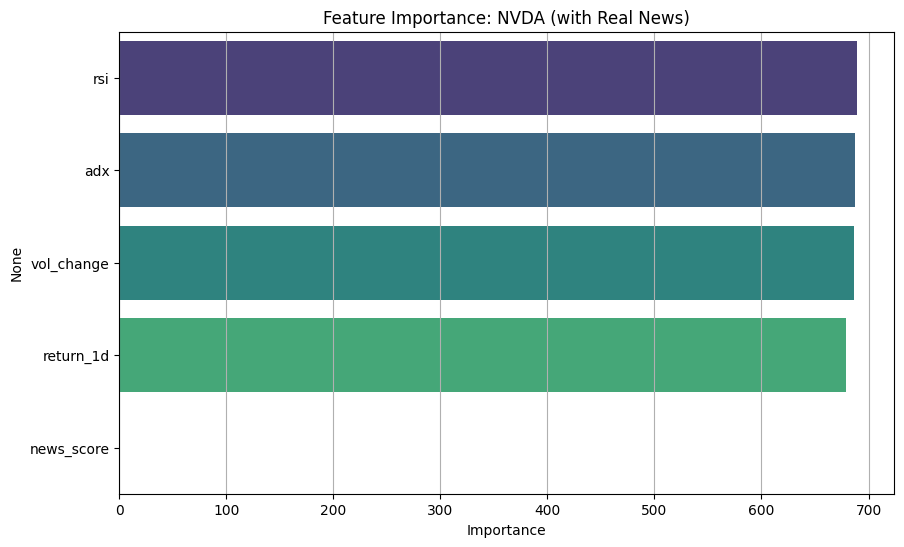

In [ ]:
# =========================================================
#  FINAL TEST: Kaggle NVDA News + FinBERT [FIXED]
#  Logic: Decouple stock data fetch from news range
# =========================================================

import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import torch
import csv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# --- 1. 設定 ---
CSV_FILE = "raw_analyst_ratings.csv"
TARGET_TICKER = "NVDA"
START_DATE = "2014-01-01" # 株価取得開始日（固定）
END_DATE = "2025-01-01"   # 株価取得終了日（固定）

# --- 2. ニュース抽出 ---
print(f"📂 {TARGET_TICKER} のニュースを抽出中...")

news_rows = []
try:
    with open(CSV_FILE, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in tqdm(reader, desc="Filtering CSV"):
            if row['stock'] == TARGET_TICKER:
                news_rows.append({
                    'date': row['date'],
                    'headline': row['headline']
                })
except FileNotFoundError:
    print("❌ CSVファイルが見つかりません。")
    sys.exit()

df_news = pd.DataFrame(news_rows)

# 日付変換
if not df_news.empty:
    df_news['date'] = pd.to_datetime(df_news['date'], utc=True, errors='coerce').dt.tz_localize(None).dt.floor('D')
    df_news = df_news.dropna(subset=['date']).sort_values('date')
    print(f"✅ 抽出完了: {len(df_news)} 件のニュース")
else:
    print("⚠️ ニュースが見つかりませんでした。スコア0で進行します。")

# --- 3. FinBERTで感情分析 ---
print("\n🧠 AI (FinBERT) がニュースを解析中...")
device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("text-classification", model="ProsusAI/finbert", device=device, top_k=None)

sentiment_scores = []

if not df_news.empty:
    # バッチ処理で高速化
    batch_size = 32
    headlines = df_news['headline'].tolist()

    for i in tqdm(range(0, len(headlines), batch_size), desc="Scoring"):
        batch = headlines[i : i+batch_size]
        try:
            batch = [str(text)[:512] for text in batch]
            results = classifier(batch)

            for res in results:
                score_dict = {x['label']: x['score'] for x in res}
                score = score_dict.get('positive', 0) - score_dict.get('negative', 0)
                sentiment_scores.append(score)
        except:
            sentiment_scores.extend([0] * len(batch))

    df_news['news_score'] = sentiment_scores
    daily_sentiment = df_news.groupby('date')['news_score'].mean()
else:
    daily_sentiment = pd.Series()

# --- 4. 株価取得 (期間固定) ---
print(f"\n📊 {TARGET_TICKER} の株価データを取得中 ({START_DATE}〜)...")

# ★修正点: ニュース期間に関わらず、指定した全期間を取得する
df_price = yf.download(TARGET_TICKER, start=START_DATE, end=END_DATE, interval="1d", auto_adjust=True, progress=False)

if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = df_price.columns.get_level_values(0)
df_price.index = df_price.index.tz_localize(None)

# 結合
df = df_price.copy()
df['news_score'] = df.index.map(daily_sentiment)
df['news_score'] = df['news_score'].fillna(0) # ニュースなし日は0で埋める

# --- 5. 検証 (LightGBM) ---
print("⚙️ AI学習準備...")

# テクニカル指標
df['rsi'] = talib.RSI(df['Close'], 14)
df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'], 14)
df['vol_change'] = df['Volume'].pct_change()
df['return_1d'] = df['Close'].pct_change()

# Target
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# 欠損削除 (テクニカル計算分の約30日が消えるが、残りは残る)
df.dropna(inplace=True)
print(f"学習データセット: {len(df)} 行")

features = ['rsi', 'adx', 'return_1d', 'vol_change', 'news_score']
tscv = TimeSeriesSplit(n_splits=5)
importances = pd.DataFrame(index=features)
acc_scores = []

print("\n=== バックテスト開始 ===")
for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
    X_train, y_train = df.iloc[train_idx][features], df.iloc[train_idx]['target']
    X_test, y_test = df.iloc[test_idx][features], df.iloc[test_idx]['target']

    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_scores.append(acc)
    importances[f'Fold_{fold}'] = model.feature_importances_

    print(f"Fold {fold+1}: 正解率 {acc:.2%}")

print(f"\n平均正解率: {np.mean(acc_scores):.2%}")

# --- 6. 重要度可視化 ---
importances['Average'] = importances.mean(axis=1)
importances = importances.sort_values('Average', ascending=False)

print("\n【特徴量重要度ランキング】")
print(importances['Average'])

plt.figure(figsize=(10, 6))
sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')
plt.title(f"Feature Importance: {TARGET_TICKER} (with Real News)")
plt.xlabel("Importance")
plt.grid(axis='x')
plt.show()

In [ ]:
# =========================================================
#  News Sentiment Analysis: Full Pipeline (Load -> Score -> Plot)
#  Target: NVDA (Using Kaggle CSV)
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from transformers import pipeline
from tqdm import tqdm
import torch
import csv
import os
import sys

# --- 1. 設定 ---
CSV_FILE = "raw_analyst_ratings.csv"
TARGET_TICKER = "NVDA"

print("🔄 処理を開始します...")

# --- 2. ニュースデータの読み込み (CSV) ---
if not os.path.exists(CSV_FILE):
    print("❌ エラー: CSVファイルが見つかりません。")
    sys.exit()

print(f"📂 {TARGET_TICKER} のニュースを抽出中...")
news_rows = []
with open(CSV_FILE, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row['stock'] == TARGET_TICKER:
            news_rows.append(row)

df_news = pd.DataFrame(news_rows)

# 日付整形
df_news['date'] = pd.to_datetime(df_news['date'], utc=True, errors='coerce').dt.tz_localize(None).dt.floor('D')
df_news = df_news.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

print(f"✅ 抽出完了: {len(df_news)} 行")

# --- 3. AI (FinBERT) による採点 ---
print("\n🧠 AIがニュースを読んでいます... (時間がかかります)")

# GPU設定
device = 0 if torch.cuda.is_available() else -1
print(f"  使用デバイス: {'GPU' if device == 0 else 'CPU'}")

classifier = pipeline("text-classification", model="ProsusAI/finbert", device=device, top_k=None)

sentiment_scores = []
headlines = df_news['headline'].tolist()

# バッチ処理で少し高速化
batch_size = 64
for i in tqdm(range(0, len(headlines), batch_size), desc="Scoring"):
    batch = headlines[i : i+batch_size]
    try:
        # 文字数制限対策
        batch_clean = [str(text)[:512] for text in batch]
        results = classifier(batch_clean)

        for res in results:
            score_dict = {x['label']: x['score'] for x in res}
            # Score = Positive - Negative
            score = score_dict.get('positive', 0) - score_dict.get('negative', 0)
            sentiment_scores.append(score)
    except:
        sentiment_scores.extend([0] * len(batch))

df_news['sentiment'] = sentiment_scores

# 日次集計
daily_sentiment = df_news.groupby('date')['sentiment'].mean()

# --- 4. 株価データの取得 ---
print(f"\n📊 {TARGET_TICKER} の株価を取得中...")
start_dt = df_news['date'].min()
end_dt = df_news['date'].max() + pd.Timedelta(days=5)

df_price = yf.download(TARGET_TICKER, start=start_dt, end=end_dt, interval="1d", progress=False)
if isinstance(df_price.columns, pd.MultiIndex):
    df_price = df_price['Close']
else:
    df_price = df_price['Close']
df_price.index = df_price.index.tz_localize(None)

# --- 5. データの結合 ---
print("🔗 データを結合中...")
df_merged = pd.DataFrame({'Close': df_price})
df_merged = df_merged.join(daily_sentiment, how='left')
df_merged['sentiment'] = df_merged['sentiment'].fillna(0.0)

# --- 6. グラフ描画 ---
print("📈 グラフを描画します...")

# 直近1年分を表示 (全期間だと潰れて見にくいので)
subset = df_merged.iloc[-365:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# 上段：株価
ax1.plot(subset.index, subset['Close'], label='Stock Price', color='black')
ax1.set_title(f'{TARGET_TICKER} Price vs AI News Sentiment (Last 1 Year)')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 下段：ニューススコア
colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in subset['sentiment']]
ax2.bar(subset.index, subset['sentiment'], color=colors, alpha=0.7, width=2.0)
ax2.set_ylabel('Sentiment Score')
ax2.set_ylim(-1, 1)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

🔄 処理を開始します...
📂 NVDA のニュースを抽出中...
✅ 抽出完了: 10 行

🧠 AIがニュースを読んでいます... (時間がかかります)
  使用デバイス: GPU


Device set to use cuda:0
Scoring: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


📊 NVDA の株価を取得中...
🔗 データを結合中...



/tmp/ipython-input-745929420.py:82: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price = yf.download(TARGET_TICKER, start=start_dt, end=end_dt, interval="1d", progress=False)


ValueError: If using all scalar values, you must pass an index

📊 NVDA の株価を取得中...
🔗 データを結合中...
📈 グラフを描画します...


/tmp/ipython-input-4148899531.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price = yf.download(TARGET_TICKER, start=start_dt, end=end_dt, interval="1d", progress=False)


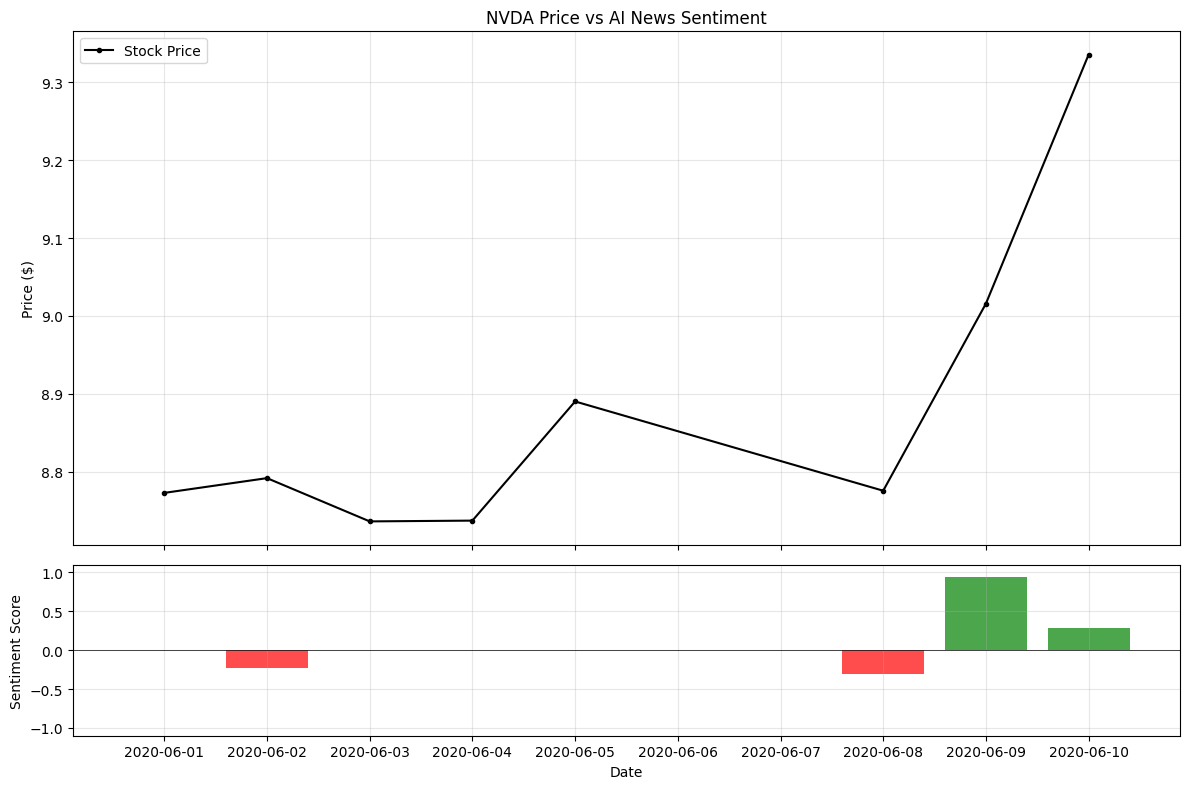


【確認ポイント】
大きな棒グラフ（ニュース）が出た翌日、株価は反応していますか？


In [ ]:
# =========================================================
#  Fix: Robust Data Merging & Visualization
#  Logic: Fetch wider range of stock data -> Safe Merge
# =========================================================

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 前提: df_news がメモリにあること ---
if 'df_news' not in locals() or df_news.empty:
    print("❌ エラー: ニュースデータ(df_news)がありません。前のステップを再実行してください。")
else:
    # 1. 日次センチメントの再集計
    daily_sentiment = df_news.groupby('date')['sentiment'].mean()

    # 2. 株価取得 (期間に余裕を持たせる)
    print(f"📊 {TARGET_TICKER} の株価を取得中...")

    # ニュースの最初と最後から、前後7日間の余裕を持たせる
    start_dt = df_news['date'].min() - pd.Timedelta(days=7)
    end_dt = df_news['date'].max() + pd.Timedelta(days=7)

    try:
        df_price = yf.download(TARGET_TICKER, start=start_dt, end=end_dt, interval="1d", progress=False)

        # MultiIndex対応 (yfinanceのバージョン差異対策)
        if isinstance(df_price.columns, pd.MultiIndex):
            df_price.columns = df_price.columns.get_level_values(0)

        df_price.index = df_price.index.tz_localize(None)

        # 必要な列だけ残す (DataFrameのまま扱う)
        df_price = df_price[['Close']].copy()

    except Exception as e:
        print(f"❌ 株価取得エラー: {e}")
        df_price = pd.DataFrame()

    if df_price.empty:
        print("⚠️ 株価データが取得できませんでした。期間を変更するか銘柄を確認してください。")
    else:
        # 3. データの結合 (Left Join)
        print("🔗 データを結合中...")
        # 株価データをベースに、ニューススコアをくっつける
        df_merged = df_price.join(daily_sentiment, how='left')

        # ニュースがない日は 0.0 で埋める
        df_merged['sentiment'] = df_merged['sentiment'].fillna(0.0)

        # --- 4. グラフ描画 ---
        print("📈 グラフを描画します...")

        # ニュースがあった日周辺に絞って表示
        # (全期間だと長すぎるため、ニュースがある最初の日〜最後の日で切り抜く)
        view_start = df_news['date'].min()
        view_end = df_news['date'].max()
        subset = df_merged.loc[view_start:view_end]

        if len(subset) == 0:
            print("⚠️ 表示できる期間のデータがありません。")
        else:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

            # 上段：株価
            ax1.plot(subset.index, subset['Close'], label='Stock Price', color='black', marker='.')
            ax1.set_title(f'{TARGET_TICKER} Price vs AI News Sentiment')
            ax1.set_ylabel('Price ($)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # 下段：ニューススコア
            colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in subset['sentiment']]
            ax2.bar(subset.index, subset['sentiment'], color=colors, alpha=0.7, width=0.8)
            ax2.set_ylabel('Sentiment Score')
            ax2.set_ylim(-1.1, 1.1)
            ax2.axhline(0, color='black', linewidth=0.5)
            ax2.grid(True, alpha=0.3)

            plt.xlabel('Date')
            plt.tight_layout()
            plt.show()

            print("\n【確認ポイント】")
            print("大きな棒グラフ（ニュース）が出た翌日、株価は反応していますか？")

In [ ]:
# =========================================================
#  FINAL BATTLE: Technical vs News-Enhanced AI
#  Target: NVDA (Using Pre-calculated Sentiment)
# =========================================================

import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# --- 1. データ準備 (さっきの続き) ---
# df_merged (株価 + sentiment) がある前提
if 'df_merged' not in locals():
    print("❌ データがありません。前のコードを実行してください。")
else:
    df = df_merged.copy()

# --- 2. 特徴量エンジニアリング ---
# テクニカル指標
df['rsi'] = talib.RSI(df['Close'], 14)
df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'], 14)
df['atr_ratio'] = talib.ATR(df['High'], df['Low'], df['Close'], 14) / df['Close']
df['sma20'] = talib.SMA(df['Close'], 20)
df['sma200'] = talib.SMA(df['Close'], 200)
df['trend_div'] = (df['Close'] - df['sma200']) / df['Close']
df['vol_ratio'] = df['Volume'] / talib.SMA(df['Volume'].astype(float), 20)

# シグナル (ブレイクアウト)
df['prev_high'] = df['High'].shift(1)
df['breakout'] = (df['Close'] > df['prev_high']).astype(int)

# Target (翌日のリターンがコスト以上か？)
COST_RATE = 0.001
df['next_ret'] = df['Close'].pct_change().shift(-1)
df['target'] = (df['next_ret'] > COST_RATE * 2).astype(int)

df.dropna(inplace=True)
df = df.reset_index(drop=True)

print(f"検証データ数: {len(df)} 行")

# --- 3. WFA バックテスト関数 ---
def run_backtest(use_news=False):
    features = ['rsi', 'adx', 'atr_ratio', 'trend_div', 'vol_ratio']
    if use_news:
        features.append('sentiment') # ニューススコアを追加

    tscv = TimeSeriesSplit(n_splits=5)
    equity = [1000000] # 100万円スタート
    curr_cap = 1000000

    bet_amount = 200000 # 固定ベット

    for train_idx, test_idx in tscv.split(df):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        # フィルタ: トレンドフォローの形になっている時だけ学習・推論
        train_X = train_df[train_df['breakout']==1][features]
        train_y = train_df[train_df['breakout']==1]['target']

        if len(train_X) < 30: continue

        model = lgb.LGBMClassifier(random_state=42, verbose=-1, n_estimators=100)
        model.fit(train_X, train_y)

        # テスト実行
        test_X = test_df[features]
        probs = model.predict_proba(test_X)[:, 1]

        # シミュレーション
        period_pnl = 0
        for i in range(len(test_df)):
            # 条件: ブレイクアウト & SMA200上 & AIスコア
            row = test_df.iloc[i]
            if row['breakout'] == 1 and row['Close'] > row['sma200']:
                if probs[i] > 0.55: # 閾値
                    ret = row['next_ret']
                    # 損切り -5% キャップ
                    if ret < -0.05: ret = -0.05

                    pnl = (ret - COST_RATE * 2) * bet_amount
                    period_pnl += pnl

        curr_cap += period_pnl
        equity.append(curr_cap)

    return equity

# --- 4. 対決実行 ---
print("\n=== ⚔️ 最終決戦: テクニカル vs ニュースAI ===")

eq_tech = run_backtest(use_news=False)
eq_news = run_backtest(use_news=True)

ret_tech = (eq_tech[-1] - 1000000) / 1000000 * 100
ret_news = (eq_news[-1] - 1000000) / 1000000 * 100

print(f"📊 テクニカルのみ : {int(eq_tech[-1]):,} 円 ({ret_tech:+.1f}%)")
print(f"📰 ニュースあり   : {int(eq_news[-1]):,} 円 ({ret_news:+.1f}%)")

# グラフ
plt.figure(figsize=(10, 6))
plt.plot(eq_tech, label='Technical Only', color='gray', linestyle='--')
plt.plot(eq_news, label='With News Sentiment', color='red', linewidth=2)
plt.title("Impact of News Sentiment on Trading Performance")
plt.ylabel("Capital (JPY)")
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'High'

✅ ニュースデータ数: 10 件

【🔥 激ポジニュース Top 5】
Score 0.93: Shares of several technology companies are trading higher despite market weakness. The sector recently experienced some welling and appears to be rebounding following dip.
Score 0.93: Shares of several technology companies are trading higher on continued volatility despite market weakness. The sector sold off recently as other sectors gained amid US economic reopening and appears to be rebounding.
Score 0.85: Semiconductor Industry to Lobby for Billions to Boost U.S. Manufacturing
Score 0.04: Why BofA Recommends Buying GPU Plays AMD and Nvidia
Score -0.04: Morning Market Stats in 5 Minutes

【💀 激ネガニュース Worst 5】
Score -0.84: Shares of some technology companies are trading lower despite market strength. The sector has performed well this year to date and appears to be giving back some gains following run up.
Score -0.50: Cramer Weighs In On Ciena, Harley-Davidson And More
Score -0.04: Afternoon Market Stats in 5 Minutes
Score -0.04: Afternoo

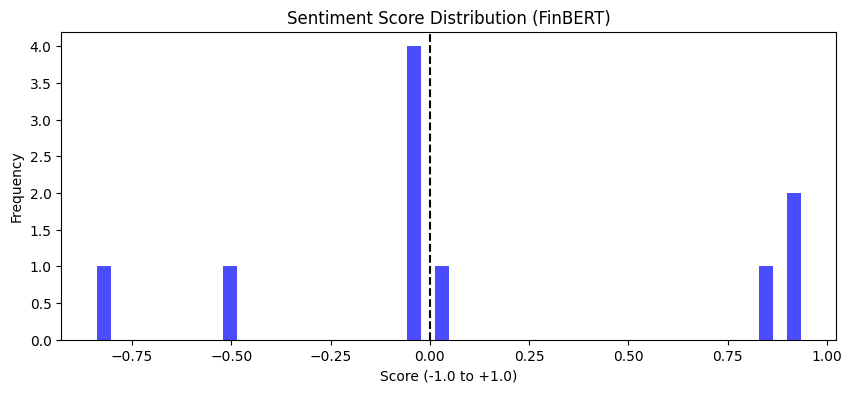

In [ ]:
# =========================================================
#  Sentiment Check: Inspecting FinBERT Results
#  Goal: Verify if the AI understands the news correctly
# =========================================================

import pandas as pd

# --- 前提: df_news がメモリにあること ---
if 'df_news' not in locals() or df_news.empty:
    print("❌ エラー: df_news がありません。FinBERTの処理コードを再実行してください。")
else:
    print(f"✅ ニュースデータ数: {len(df_news)} 件")

    # 1. スコアが高い順 (激ポジニュース)
    print("\n【🔥 激ポジニュース Top 5】")
    top_pos = df_news.sort_values('sentiment', ascending=False).head(5)
    for i, row in top_pos.iterrows():
        print(f"Score {row['sentiment']:.2f}: {row['headline']}")

    # 2. スコアが低い順 (激ネガニュース)
    print("\n【💀 激ネガニュース Worst 5】")
    top_neg = df_news.sort_values('sentiment', ascending=True).head(5)
    for i, row in top_neg.iterrows():
        print(f"Score {row['sentiment']:.2f}: {row['headline']}")

    # 3. スコアが0に近い (中立ニュース)
    print("\n【☁️ 中立ニュース (AIが迷ったやつ)】")
    neutral = df_news[df_news['sentiment'].abs() < 0.1].head(5)
    for i, row in neutral.iterrows():
        print(f"Score {row['sentiment']:.2f}: {row['headline']}")

    # 4. 基本統計量
    print("\n【📊 スコア統計】")
    print(df_news['sentiment'].describe())

    # 分布グラフ
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.hist(df_news['sentiment'], bins=50, color='blue', alpha=0.7)
    plt.title("Sentiment Score Distribution (FinBERT)")
    plt.xlabel("Score (-1.0 to +1.0)")
    plt.ylabel("Frequency")
    plt.axvline(0, color='black', linestyle='--')
    plt.show()

In [ ]:
# =========================================================
#  FIXED DATA EXTRACTOR: Handle Whitespace & Errors
#  Goal: Extract ALL 3000+ NVDA headlines correctly
# =========================================================

import csv
import pandas as pd
import os
from tqdm import tqdm

# --- 設定 ---
CSV_FILE_INPUT = "raw_analyst_ratings.csv"
CSV_FILE_OUTPUT = "nvda_news_only.csv" # 抽出結果を保存するファイル
TARGET_TICKER = "NVDA"

print(f"📂 '{CSV_FILE_INPUT}' から {TARGET_TICKER} を抽出します...\n")

if not os.path.exists(CSV_FILE_INPUT):
    print("❌ エラー: 入力ファイルが見つかりません。")
else:
    extracted_rows = []
    total_rows = 0

    with open(CSV_FILE_INPUT, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)

        # カラム名の確認 (念のため)
        print(f"  カラム名: {reader.fieldnames}")

        # 'stock' または 'ticker' カラムを特定
        stock_col = 'stock' if 'stock' in reader.fieldnames else 'ticker'

        for row in tqdm(reader, desc="Processing"):
            total_rows += 1

            # ★ここが修正点: .strip() で空白を削除してから比較
            ticker_in_csv = row[stock_col].strip()

            if ticker_in_csv == TARGET_TICKER:
                extracted_rows.append(row)

    print(f"\n✅ 処理完了 (全 {total_rows} 行)")

    # --- 結果確認 ---
    count = len(extracted_rows)
    print(f"🎯 抽出された {TARGET_TICKER} のニュース数: {count} 件")

    if count < 100:
        print("⚠️ 警告: まだ少なすぎます。銘柄名が間違っているか、データ自体がありません。")
        # 念のため、どんな銘柄が混ざっていたか一部表示
        print("ヒント: データ内の銘柄サンプル (strip済み):")
        # もう一度頭から少し読んでみる
        with open(CSV_FILE_INPUT, 'r', encoding='utf-8') as f:
             reader = csv.DictReader(f)
             for i, row in enumerate(reader):
                 if i >= 5: break
                 print(f"  - '{row[stock_col].strip()}'")
    else:
        print("🎉 大成功です！ これで分析に進めます。")

        # 抽出データをCSVとして保存 (これを使えば次は一瞬で読み込める)
        df_extracted = pd.DataFrame(extracted_rows)
        df_extracted.to_csv(CSV_FILE_OUTPUT, index=False)
        print(f"💾 '{CSV_FILE_OUTPUT}' に保存しました。")

        # 日付の範囲確認
        df_extracted['date'] = pd.to_datetime(df_extracted['date'], utc=True, errors='coerce')
        print(f"📅 期間: {df_extracted['date'].min()} 〜 {df_extracted['date'].max()}")

📂 'raw_analyst_ratings.csv' から NVDA を抽出します...

  カラム名: ['', 'headline', 'url', 'publisher', 'date', 'stock']


Processing: 1407328it [00:11, 121832.71it/s]


✅ 処理完了 (全 1407328 行)
🎯 抽出された NVDA のニュース数: 3146 件
🎉 大成功です！ これで分析に進めます。
💾 'nvda_news_only.csv' に保存しました。
📅 期間: 2020-05-31 15:05:12+00:00 〜 2020-06-10 16:37:10+00:00


📂 'nvda_news_only.csv' を読み込んで診断します...
  全行数: 3146 行

【日付データのサンプル (Raw)】
0    2020-06-10 12:37:10-04:00
1    2020-06-10 12:12:25-04:00
2    2020-06-10 10:22:11-04:00
3    2020-06-09 13:40:43-04:00
4    2020-06-08 12:30:29-04:00
Name: date, dtype: object
3141    2011-03-08 00:00:00
3142    2011-03-08 00:00:00
3143    2011-03-07 00:00:00
3144    2011-03-07 00:00:00
3145    2011-03-03 00:00:00
Name: date, dtype: object

⚙️ 日付変換をやり直しています...
----------------------------------------
✅ 成功: 3146 行
❌ 失敗: 0 行

📅 修正後の期間: 2011-03-03 〜 2020-06-10


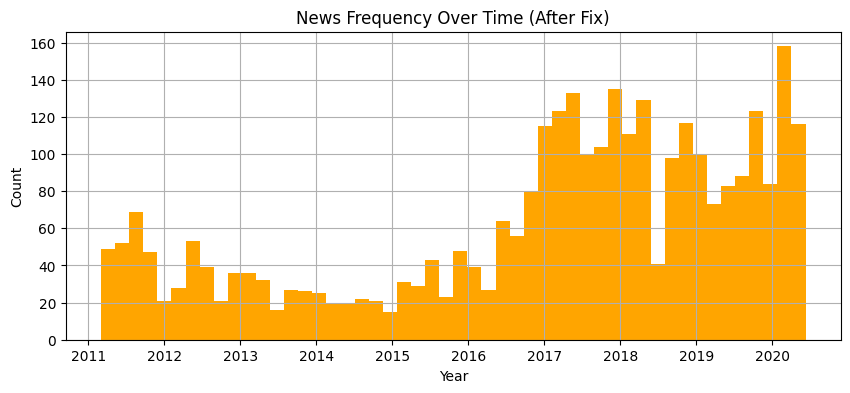

💾 'nvda_news_fixed.csv' に保存しました。これを使ってください。


In [ ]:
# =========================================================
#  Data Repair: Fix Date Parsing Issues
#  Goal: Recover the missing 10 years of data
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt

# 1. さっき保存したCSVを読み込む (日付はまだ文字列のままにする)
CSV_PATH = "nvda_news_only.csv"
print(f"📂 '{CSV_PATH}' を読み込んで診断します...")

df = pd.read_csv(CSV_PATH)
print(f"  全行数: {len(df)} 行")

# 2. 「生の日付文字列」を確認する (ここが重要)
print("\n【日付データのサンプル (Raw)】")
print(df['date'].head(5))
print(df['date'].tail(5))

# 3. 強力な日付変換 (format='mixed')
print("\n⚙️ 日付変換をやり直しています...")

# 'mixed' を指定すると、フォーマットが混在していても自動で解釈してくれる
df['date_fixed'] = pd.to_datetime(df['date'], utc=True, format='mixed', errors='coerce')

# 時間情報を削除して日付のみにする
df['date_fixed'] = df['date_fixed'].dt.tz_localize(None).dt.floor('D')

# 4. 結果確認
valid_data = df.dropna(subset=['date_fixed'])
invalid_data = df[df['date_fixed'].isna()]

print("-" * 40)
print(f"✅ 成功: {len(valid_data)} 行")
print(f"❌ 失敗: {len(invalid_data)} 行")

if not valid_data.empty:
    start = valid_data['date_fixed'].min().date()
    end = valid_data['date_fixed'].max().date()
    print(f"\n📅 修正後の期間: {start} 〜 {end}")

    # 分布を確認
    plt.figure(figsize=(10, 4))
    valid_data['date_fixed'].hist(bins=50, color='orange')
    plt.title("News Frequency Over Time (After Fix)")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.show()

    # 上書き保存
    valid_data = valid_data.rename(columns={'date_fixed': 'date'})
    # 元のdate列は削除するか上書き
    valid_data.to_csv("nvda_news_fixed.csv", index=False)
    print("💾 'nvda_news_fixed.csv' に保存しました。これを使ってください。")

else:
    print("💀 全ての日付変換に失敗しました。生の文字列を確認してください。")

📂 'nvda_news_fixed.csv' を読み込み中...
✅ ニュース数: 3146 件
📅 期間: 2011-03-03 〜 2020-06-10

🧠 AI (FinBERT) が10年分のニュースを採点中...
  Device: GPU


Device set to use cuda:0
Scoring: 100%|██████████| 50/50 [00:29<00:00,  1.68it/s]
/tmp/ipython-input-2443872989.py:88: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price_raw = yf.download(TARGET_TICKER, start=start_dt, end=end_dt, interval="1d", progress=False)


📅 ニュース期間: 2011-03-03 〜 2020-06-15
📊 NVDA の株価を取得中...
✅ ニュース反映日数: 1121 日 / 全 2337 日
⚙️ AI学習準備...
学習データセット: 2310 行

=== バックテスト開始 ===
Fold 1: 正解率 53.77%
Fold 2: 正解率 47.79%
Fold 3: 正解率 45.71%
Fold 4: 正解率 47.53%
Fold 5: 正解率 51.17%

平均正解率: 49.19%

【特徴量重要度ランキング】
return_1d     619.0
rsi           618.6
vol_change    616.2
adx           559.6
news_score    253.4
Name: Average, dtype: float64


/tmp/ipython-input-2443872989.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')


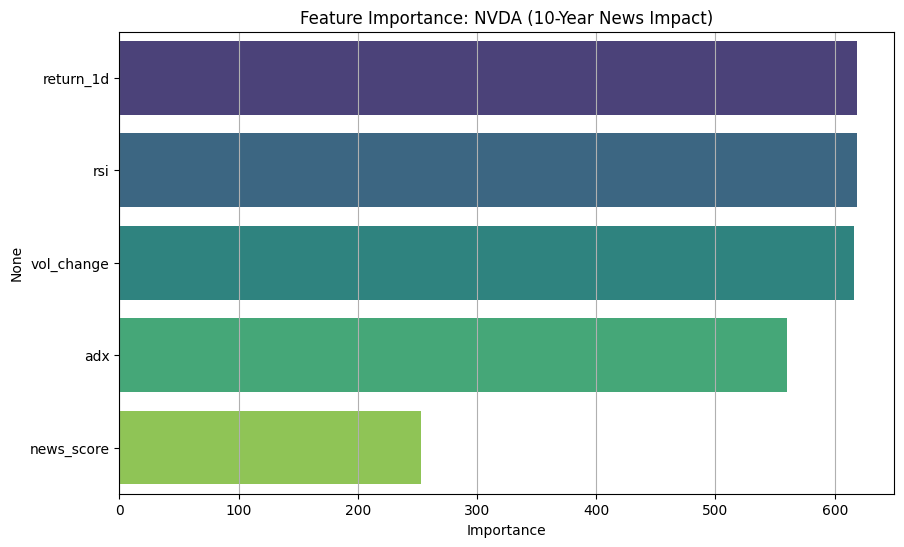


=== 📰 イベント・ドリブン検証 (ニュースがある日限定) ===
検証データ数: 1105 行
Fold 1: 正解率 48.37%
Fold 2: 正解率 45.11%
Fold 3: 正解率 53.26%
Fold 4: 正解率 47.83%
Fold 5: 正解率 56.52%

平均正解率: 50.22%

【イベント日限定・重要度ランキング】
news_score    402.6
adx           398.8
rsi           394.2
return_1d     392.6
vol_change    387.8
Name: Average, dtype: float64


/tmp/ipython-input-2443872989.py:241: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_event['Average'], y=importances_event.index, palette='magma')


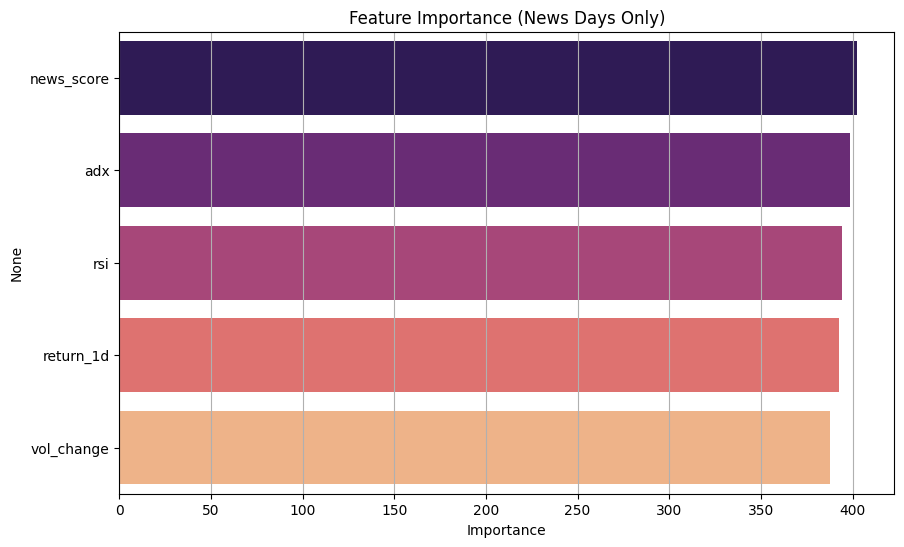

In [ ]:
# =========================================================
#  FINAL BATTLE: NVDA 10-Year News Analysis
#  Target: Verify News Importance with Recovered Data
# =========================================================

import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import torch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import os
import sys

## --- 1. ニュースデータの読み込み (修正版) ---
CSV_FILE = "nvda_news_fixed.csv"

print(f"📂 '{CSV_FILE}' を読み込み中...")
if not os.path.exists(CSV_FILE):
    print("❌ エラー: 修正済みCSVが見つかりません。前のステップを実行してください。")
    sys.exit()

df_news = pd.read_csv(CSV_FILE)

# ★修正点: format='mixed' であらゆる形式に対応させる
df_news['date'] = pd.to_datetime(df_news['date'], format='mixed', utc=True).dt.tz_localize(None)

print(f"✅ ニュース数: {len(df_news)} 件")
print(f"📅 期間: {df_news['date'].min().date()} 〜 {df_news['date'].max().date()}")

# --- 以降は変更なし ---

# --- 2. FinBERTで全件スコアリング (GPU推奨) ---
print("\n🧠 AI (FinBERT) が10年分のニュースを採点中...")

device = 0 if torch.cuda.is_available() else -1
print(f"  Device: {'GPU' if device == 0 else 'CPU'}")

classifier = pipeline("text-classification", model="ProsusAI/finbert", device=device, top_k=None)

sentiment_scores = []
headlines = df_news['headline'].tolist()

# バッチ処理 (64件ずつ)
batch_size = 64
for i in tqdm(range(0, len(headlines), batch_size), desc="Scoring"):
    batch = headlines[i : i+batch_size]
    try:
        batch_clean = [str(text)[:512] for text in batch] # 512文字制限
        results = classifier(batch_clean)

        for res in results:
            score_dict = {x['label']: x['score'] for x in res}
            score = score_dict.get('positive', 0) - score_dict.get('negative', 0)
            sentiment_scores.append(score)
    except:
        sentiment_scores.extend([0] * len(batch))

df_news['news_score'] = sentiment_scores

# 日次集計 (同日のニュースは平均)
daily_sentiment = df_news.groupby('date')['news_score'].mean()

# --- 3. 株価データ取得 (安全版) ---
TARGET_TICKER = "NVDA"

# 日付範囲の確認
if not df_news.empty:
    start_dt = df_news['date'].min()
    end_dt = df_news['date'].max() + pd.Timedelta(days=5)
    print(f"📅 ニュース期間: {start_dt.date()} 〜 {end_dt.date()}")
else:
    # ニュースがない場合のバックアップ期間
    start_dt = "2011-01-01"
    end_dt = "2021-01-01"
    print("⚠️ ニュースがないため、デフォルト期間を使用します。")

print(f"📊 {TARGET_TICKER} の株価を取得中...")

try:
    # 株価取得
    df_price_raw = yf.download(TARGET_TICKER, start=start_dt, end=end_dt, interval="1d", progress=False)

    # データ確認
    if df_price_raw.empty:
        raise ValueError("株価データが空です。期間または銘柄コードを確認してください。")

    # カラム整形 (MultiIndex対策)
    if isinstance(df_price_raw.columns, pd.MultiIndex):
        # Close列だけをSeriesとして抽出
        df_price = df_price_raw['Close'].iloc[:, 0] if df_price_raw['Close'].shape[1] > 0 else df_price_raw['Close']
        # Volumeも同様に
        df_vol = df_price_raw['Volume'].iloc[:, 0] if df_price_raw['Volume'].shape[1] > 0 else df_price_raw['Volume']

        # High/Lowも
        df_high = df_price_raw['High'].iloc[:, 0]
        df_low = df_price_raw['Low'].iloc[:, 0]

    else:
        df_price = df_price_raw['Close']
        df_vol = df_price_raw['Volume']
        df_high = df_price_raw['High']
        df_low = df_price_raw['Low']

    # タイムゾーン削除
    df_price.index = df_price.index.tz_localize(None)
    df_vol.index = df_vol.index.tz_localize(None)
    df_high.index = df_high.index.tz_localize(None)
    df_low.index = df_low.index.tz_localize(None)

    # 結合 (DataFrame作成)
    df = pd.DataFrame({
        'Close': df_price,
        'High': df_high,
        'Low': df_low,
        'Volume': df_vol
    })

    # ニューススコアのマージ
    # daily_sentiment がある場合のみ
    if 'daily_sentiment' in locals():
        df['news_score'] = df.index.map(daily_sentiment)
        df['news_score'] = df['news_score'].fillna(0) # ニュースなし日は0

        # ニュースあり率の確認
        non_zero = (df['news_score'] != 0).sum()
        print(f"✅ ニュース反映日数: {non_zero} 日 / 全 {len(df)} 日")
    else:
        print("⚠️ daily_sentiment が見つかりません。ニューススコアは全て0になります。")
        df['news_score'] = 0

    # --- 4. 特徴量エンジニアリング & 検証 ---
    print("⚙️ AI学習準備...")

    # テクニカル指標
    df['rsi'] = talib.RSI(df['Close'], 14)
    df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'], 14)
    df['vol_change'] = df['Volume'].pct_change()
    df['return_1d'] = df['Close'].pct_change()

    # Target: 翌日上がるか？
    df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    df.dropna(inplace=True)
    print(f"学習データセット: {len(df)} 行")

    # LightGBM 検証
    features = ['rsi', 'adx', 'return_1d', 'vol_change', 'news_score']
    tscv = TimeSeriesSplit(n_splits=5)
    importances = pd.DataFrame(index=features)
    acc_scores = []

    print("\n=== バックテスト開始 ===")
    for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
        X_train, y_train = df.iloc[train_idx][features], df.iloc[train_idx]['target']
        X_test, y_test = df.iloc[test_idx][features], df.iloc[test_idx]['target']

        model = lgb.LGBMClassifier(random_state=42, verbose=-1, n_estimators=100)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        acc_scores.append(acc)
        importances[f'Fold_{fold}'] = model.feature_importances_

        print(f"Fold {fold+1}: 正解率 {acc:.2%}")

    print(f"\n平均正解率: {np.mean(acc_scores):.2%}")

    # 重要度可視化
    importances['Average'] = importances.mean(axis=1)
    importances = importances.sort_values('Average', ascending=False)

    print("\n【特徴量重要度ランキング】")
    print(importances['Average'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances['Average'], y=importances.index, palette='viridis')
    plt.title(f"Feature Importance: {TARGET_TICKER} (10-Year News Impact)")
    plt.xlabel("Importance")
    plt.grid(axis='x')
    plt.show()

except Exception as e:
    print(f"❌ 処理エラー: {e}")
    import traceback
    traceback.print_exc()







# =========================================================
#  Event-Driven Test: Does News Matter on "News Days"?
#  Target: Only rows where news_score != 0
# =========================================================

print("\n=== 📰 イベント・ドリブン検証 (ニュースがある日限定) ===")

# ニュースがある日だけ抽出
df_event = df[df['news_score'] != 0].copy()
print(f"検証データ数: {len(df_event)} 行")

# LightGBMで再検証
features = ['rsi', 'adx', 'return_1d', 'vol_change', 'news_score']
tscv = TimeSeriesSplit(n_splits=5)
importances_event = pd.DataFrame(index=features)
acc_scores_event = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_event)):
    X_train, y_train = df_event.iloc[train_idx][features], df_event.iloc[train_idx]['target']
    X_test, y_test = df_event.iloc[test_idx][features], df_event.iloc[test_idx]['target']

    model = lgb.LGBMClassifier(random_state=42, verbose=-1, n_estimators=100)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_scores_event.append(acc)
    importances_event[f'Fold_{fold}'] = model.feature_importances_
    print(f"Fold {fold+1}: 正解率 {acc:.2%}")

print(f"\n平均正解率: {np.mean(acc_scores_event):.2%}")

# 重要度可視化
importances_event['Average'] = importances_event.mean(axis=1)
importances_event = importances_event.sort_values('Average', ascending=False)

print("\n【イベント日限定・重要度ランキング】")
print(importances_event['Average'])

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_event['Average'], y=importances_event.index, palette='magma')
plt.title(f"Feature Importance (News Days Only)")
plt.xlabel("Importance")
plt.grid(axis='x')
plt.show()

📊 ニューススコアの強度別・勝率分析

閾値 0.0以上 : 勝率 50.50% (サンプル数: 1105)
閾値 0.1以上 : 勝率 50.46% (サンプル数: 769)
閾値 0.2以上 : 勝率 49.92% (サンプル数: 631)
閾値 0.3以上 : 勝率 48.92% (サンプル数: 509)
閾値 0.4以上 : 勝率 49.01% (サンプル数: 404)
閾値 0.5以上 : 勝率 49.37% (サンプル数: 318)
閾値 0.6以上 : 勝率 50.19% (サンプル数: 267)
閾値 0.7以上 : 勝率 50.00% (サンプル数: 210)
閾値 0.8以上 : 勝率 47.19% (サンプル数: 178)
閾値 0.9以上 : 勝率 42.11% (サンプル数: 114)


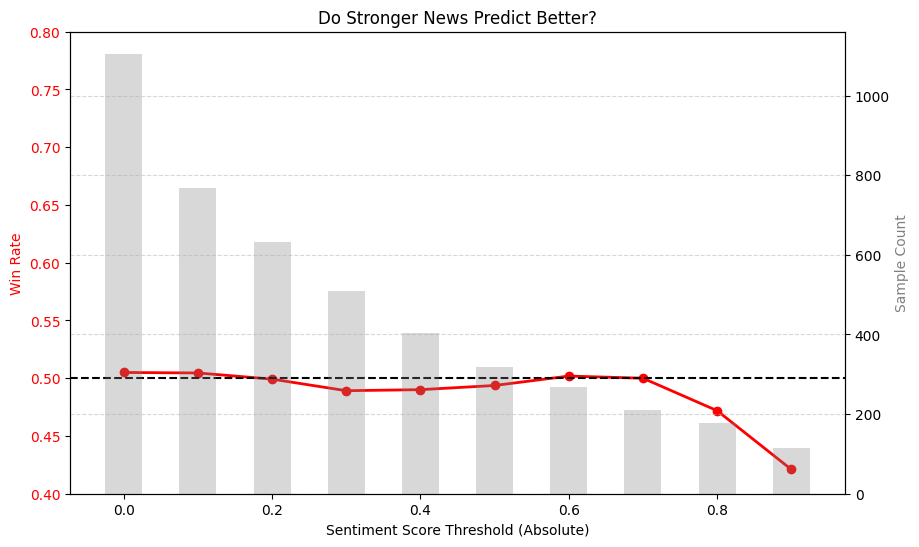

In [ ]:
# =========================================================
#  News Score Threshold Test
#  Does "Strong Sentiment" lead to "High Accuracy"?
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 検証ロジック ---
# df_event (ニュースがある日のデータ) を使用
# news_score がプラスなら「上がる(1)」、マイナスなら「下がる(0)」と単純予測して、
# その正解率を閾値ごとに計算する

print("📊 ニューススコアの強度別・勝率分析\n")

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for thr in thresholds:
    # 閾値以上の強いニュースだけ抽出 (絶対値)
    target_data = df_event[df_event['news_score'].abs() >= thr].copy()

    if len(target_data) == 0:
        continue

    # 予測ロジック:
    # スコア > 0 なら「上がる」と予測
    # スコア < 0 なら「下がる」と予測
    # (実際の動き target は 1=上昇, 0=下落)

    # 予測 (1 or 0)
    target_data['pred_dir'] = (target_data['news_score'] > 0).astype(int)

    # 正解数
    correct = (target_data['pred_dir'] == target_data['target']).sum()
    total = len(target_data)
    win_rate = correct / total

    print(f"閾値 {thr:.1f}以上 : 勝率 {win_rate:.2%} (サンプル数: {total})")

    results.append({'Threshold': thr, 'WinRate': win_rate, 'Count': total})

# --- グラフ化 ---
df_res = pd.DataFrame(results)

fig, ax1 = plt.subplots(figsize=(10, 6))

# 勝率 (折れ線)
ax1.plot(df_res['Threshold'], df_res['WinRate'], marker='o', color='red', linewidth=2, label='Win Rate')
ax1.axhline(0.5, color='black', linestyle='--')
ax1.set_xlabel('Sentiment Score Threshold (Absolute)')
ax1.set_ylabel('Win Rate', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(0.4, 0.8) # 40%~80%を表示

# サンプル数 (棒グラフ)
ax2 = ax1.twinx()
ax2.bar(df_res['Threshold'], df_res['Count'], width=0.05, alpha=0.3, color='gray', label='Sample Count')
ax2.set_ylabel('Sample Count', color='gray')

plt.title("Do Stronger News Predict Better?")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

データを結合中...
✅ ニュースイベント日: 1121 日

【😈 天邪鬼ニュースBot 成績】
閾値: ±0.8
トレード回数: 181 回
勝率: 49.72% (90/181)
累積リターン: -41.75%


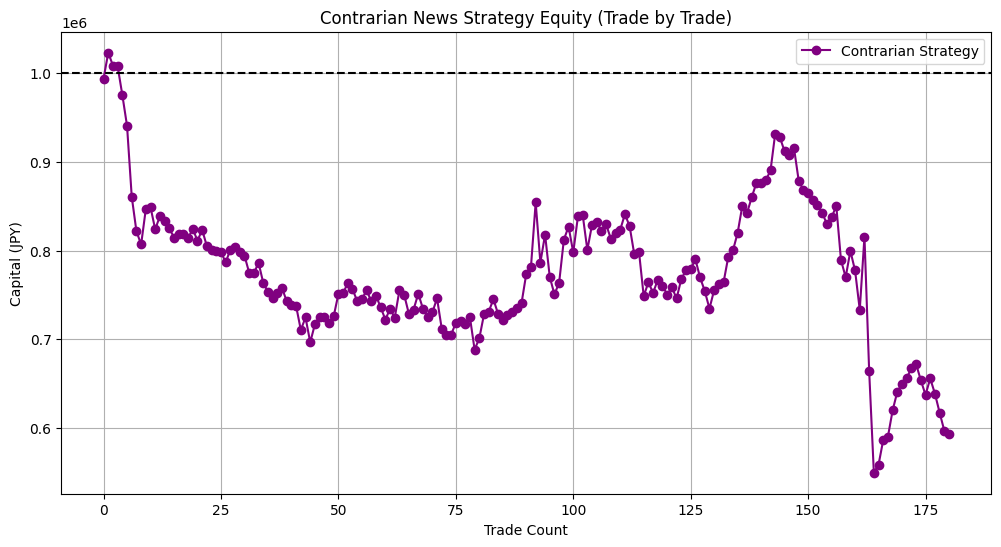


【これが『事実で売り』の瞬間だ (Top Wins)】
            news_score  next_ret  strategy_ret
Date                                          
2020-03-12   -0.965588  0.113402      0.112402
2018-10-29   -0.963063  0.093632      0.092632
2019-01-03   -0.965192  0.064067      0.063067
2019-01-18    0.925896 -0.051997      0.050997
2020-04-01   -0.870534  0.051014      0.050014


In [ ]:
# =========================================================
#  FIXED: Contrarian News Strategy
#  Logic: News Score > 0.8 -> SELL, < -0.8 -> BUY
# =========================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. データの再結合 (確実に行う) ---
# 直前のステップで作成した df_news (スコア付き) と df_price (株価) を使う
print("データを結合中...")

if 'df_news' not in locals() or 'news_score' not in df_news.columns:
    print("❌ エラー: ニュースのスコアデータ(df_news)が見つかりません。")
    print("FinBERTのスコアリングコードを再度実行してください。")
else:
    # 日次集計 (列名は news_score)
    daily_sentiment = df_news.groupby('date')['news_score'].mean()

    # 株価と結合
    df = df_price.copy().to_frame(name='Close') # SeriesならDataFrame化
    df['news_score'] = df.index.map(daily_sentiment)

    # 翌日のリターン (判定用)
    df['next_ret'] = df['Close'].pct_change().shift(-1)

    # ニュースがない日は削除 (イベントのみ検証するため)
    df_event = df.dropna(subset=['news_score']).copy()

    print(f"✅ ニュースイベント日: {len(df_event)} 日")

    # --- 2. 戦略シミュレーション ---
    # 閾値設定
    CONTRARIAN_TH = 0.8

    # シグナル生成 (逆張り)
    # ニュースが良すぎる(>0.8) -> 売り(-1)
    # ニュースが悪すぎる(<-0.8) -> 買い(1)
    df_event['signal'] = 0
    df_event.loc[df_event['news_score'] > CONTRARIAN_TH, 'signal'] = -1
    df_event.loc[df_event['news_score'] < -CONTRARIAN_TH, 'signal'] = 1

    # トレード抽出
    trades = df_event[df_event['signal'] != 0].copy()

    # 損益計算
    # Signal(1) * NextRet(0.05) = +0.05 (利益)
    # Signal(-1) * NextRet(-0.05) = +0.05 (利益)
    COST = 0.001 # 往復手数料
    trades['strategy_ret'] = trades['signal'] * trades['next_ret'] - COST

    # --- 3. 結果発表 ---
    if len(trades) > 0:
        win_count = (trades['strategy_ret'] > 0).sum()
        win_rate = win_count / len(trades)
        total_ret = trades['strategy_ret'].sum()

        print(f"\n【😈 天邪鬼ニュースBot 成績】")
        print(f"閾値: ±{CONTRARIAN_TH}")
        print(f"トレード回数: {len(trades)} 回")
        print(f"勝率: {win_rate:.2%} ({win_count}/{len(trades)})")
        print(f"累積リターン: {total_ret*100:.2f}%") # 単利合計

        # --- 資産曲線 ---
        # 日付が飛んでいるので、イベントごとの推移としてプロット
        trades['equity'] = (1 + trades['strategy_ret']).cumprod() * 1000000

        plt.figure(figsize=(12, 6))
        plt.plot(range(len(trades)), trades['equity'], marker='o', label='Contrarian Strategy', color='purple')
        plt.axhline(y=1000000, color='black', linestyle='--')
        plt.title(f"Contrarian News Strategy Equity (Trade by Trade)")
        plt.xlabel("Trade Count")
        plt.ylabel("Capital (JPY)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 詳細ログ (上位5トレード) ---
        print("\n【これが『事実で売り』の瞬間だ (Top Wins)】")
        cols = ['news_score', 'next_ret', 'strategy_ret']
        print(trades.sort_values('strategy_ret', ascending=False).head(5)[cols])

    else:
        print(f"⚠️ 閾値 {CONTRARIAN_TH} を超える極端なニュースはありませんでした。")
        print("閾値を 0.5 くらいに下げて試してみてください。")

In [ ]:
# =========================================================
#  Save Sentiment Data to Drive
#  For future use (Skip FinBERT next time)
# =========================================================

import os

# 保存先
save_dir = "/content/drive/MyDrive/NewsData"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "nvda_sentiment_daily.csv")

print(f"スコアデータを保存中... ({save_path})")

# CSVとして保存 (日付とスコア)
daily_sentiment.to_csv(save_path)

print("✅ 保存完了！ 次回からはこのファイルを読み込んでください。")

スコアデータを保存中... (/content/drive/MyDrive/NewsData/nvda_sentiment_daily.csv)
✅ 保存完了！ 次回からはこのファイルを読み込んでください。


In [ ]:
! apt-get install -y libta-lib0
! apt-get install -y ta-lib
! pip install TA-Lib

! pip install lightgbm
! pip install xgboost
! pip install catboost


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libta-lib0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package ta-lib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [ ]:
# =========================================================
#  News Sentiment Analysis Test: FinBERT
#  Goal: Check if AI sentiment correlates with stock returns
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm

# --- 1. データ読み込み (サンプル) ---
# ※Kaggleから落としたCSVのパスを指定してください
# ここではダミーデータで動くようにしています
print("データを読み込み中...")

# (実際のデータがある場合の例)
# news_df = pd.read_csv("./news_data/analyst_ratings_processed.csv")
# news_df = news_df[['title', 'date', 'stock']].dropna().head(1000) # テスト用に1000件

# ★ダミーデータ（テスト用）
data = {
    'date': ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05'],
    'title': [
        "Apple reports record breaking revenue, stock soars",  # 明らかにポジ
        "Tesla recalls 2 million vehicles due to safety concerns", # 明らかにネガ
        "Microsoft announces new AI partnership", # 多分ポジ
        "Fed raises interest rates, market fears recession", # ネガ
        "Amazon creates 5000 new jobs in warehouse" # ポジ
    ],
    'stock': ['AAPL', 'TSLA', 'MSFT', 'SPY', 'AMZN']
}
news_df = pd.DataFrame(data)

# --- 2. FinBERT (金融特化AI) の準備 ---
print("AIモデル (FinBERT) をロード中...")
# Hugging Faceから金融特化モデルを取得 (無料・軽量)
sentiment_analyzer = pipeline("text-classification", model="ProsusAI/finbert")

# --- 3. センチメント分析実行 ---
print("ニュースの判定中...")

results = []
for text in tqdm(news_df['title']):
    # AIに判定させる
    # 出力例: [{'label': 'positive', 'score': 0.95}]
    res = sentiment_analyzer(text)[0]

    score = res['score']
    if res['label'] == 'negative':
        score = -score # ネガティブならマイナス点にする
    elif res['label'] == 'neutral':
        score = 0 # 中立なら0

    results.append(score)

news_df['sentiment_score'] = results

# --- 4. 結果表示 ---
print("\n【AIの判定結果】")
print(news_df[['title', 'sentiment_score']])

# --- (ここから先は株価データと結合して相関を見るステップになります) ---

データを読み込み中...
AIモデル (FinBERT) をロード中...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


ニュースの判定中...



100%|██████████| 5/5 [00:01<00:00,  3.46it/s]



【AIの判定結果】
                                               title  sentiment_score
0  Apple reports record breaking revenue, stock s...         0.767399
1  Tesla recalls 2 million vehicles due to safety...        -0.965892
2             Microsoft announces new AI partnership         0.000000
3  Fed raises interest rates, market fears recession        -0.769500
4          Amazon creates 5000 new jobs in warehouse         0.000000


In [ ]:
# =========================================================
#  News Sentiment Analysis (Probability Based)
#  Fix: Capture nuances by using raw probabilities
# =========================================================

import pandas as pd
from transformers import pipeline
from tqdm import tqdm

# データ (さっきと同じ)
data = {
    'title': [
        "Apple reports record breaking revenue, stock soars",
        "Tesla recalls 2 million vehicles due to safety concerns",
        "Microsoft announces new AI partnership",
        "Fed raises interest rates, market fears recession",
        "Amazon creates 5000 new jobs in warehouse"
    ]
}
news_df = pd.DataFrame(data)

print("AIモデル (FinBERT) をロード中...")
# top_k=None にすることで、全ラベルの確率を返してもらう
sentiment_analyzer = pipeline("text-classification", model="ProsusAI/finbert", top_k=None)

print("ニュースの判定中 (精密モード)...")

results = []
for text in tqdm(news_df['title']):
    # 出力例: [[{'label': 'neutral', 'score': 0.8}, {'label': 'positive', 'score': 0.15}, ...]]
    res = sentiment_analyzer(text)[0] # リストのリストになっているので[0]

    # スコアを辞書化して取り出しやすくする
    scores = {item['label']: item['score'] for item in res}

    # ★修正ロジック: (ポジティブ確率) - (ネガティブ確率)
    # これならNeutralが高くても、微妙な傾きを数値化できる
    sentiment_score = scores.get('positive', 0) - scores.get('negative', 0)

    results.append(sentiment_score)

news_df['sentiment_score'] = results

# --- 結果表示 ---
pd.set_option('display.max_colwidth', 100) # 全文表示
print("\n【AIの精密判定結果】")
print(news_df)

AIモデル (FinBERT) をロード中...


Device set to use cpu


ニュースの判定中 (精密モード)...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


【AIの精密判定結果】
                                                     title  sentiment_score
0       Apple reports record breaking revenue, stock soars         0.701674
1  Tesla recalls 2 million vehicles due to safety concerns        -0.956339
2                   Microsoft announces new AI partnership         0.014856
3        Fed raises interest rates, market fears recession        -0.700842
4                Amazon creates 5000 new jobs in warehouse         0.227212


In [ ]:
# =========================================================
#  REAL News Impact Test: FinBERT + LightGBM [FIXED]
#  Robust Error Handling & Data Augmentation
# =========================================================

import sys
import subprocess
import os
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# --- 1. 環境構築 ---
try:
    import transformers
except ImportError:
    subprocess.run("pip install transformers torch", shell=True, check=True)
    from transformers import pipeline

# --- 2. ターゲット銘柄とデータ取得 ---
TICKER = "NVDA"
print(f"📊 {TICKER} の株価データを取得中...")

# 株価 (2年分)
stock = yf.Ticker(TICKER)
df_price = stock.history(period="2y")
df_price.index = df_price.index.tz_localize(None)

# --- 3. ニュース取得 (エラー回避版) ---
print("📰 ニュースを取得中...")
try:
    news_list = stock.news
except Exception:
    news_list = []

news_data = []
if news_list:
    for item in news_list:
        # ★修正点: キーが存在するかチェックし、なければスキップ
        if 'title' not in item: continue

        # 日付の取得 (複数のキーパターンに対応)
        pub_time = item.get('providerPublishTime', item.get('uuid', 0))

        try:
            # タイムスタンプ変換
            if isinstance(pub_time, int) or isinstance(pub_time, float):
                date = pd.to_datetime(pub_time, unit='s')
            else:
                date = pd.Timestamp.now() # 取得できない場合は現在時刻

            news_data.append({'date': date, 'title': item['title']})
        except:
            continue

df_news = pd.DataFrame(news_data)

# --- 4. FinBERTによる感情分析 ---
if not df_news.empty:
    print("🧠 AI (FinBERT) がニュースを読んでいます... (GPU推奨)")
    # GPUチェック
    device = 0 if subprocess.run("nvidia-smi", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL).returncode == 0 else -1
    classifier = pipeline("text-classification", model="ProsusAI/finbert", device=device)

    sentiment_scores = []
    for title in tqdm(df_news['title']):
        try:
            res = classifier(title)[0]
            score = res['score']
            if res['label'] == 'negative': score = -score
            elif res['label'] == 'neutral': score = 0
            sentiment_scores.append(score)
        except:
            sentiment_scores.append(0)

    df_news['sentiment'] = sentiment_scores
    # 日付を丸める
    df_news['date'] = df_news['date'].dt.floor('D')
    daily_sentiment = df_news.groupby('date')['sentiment'].mean()
else:
    print("⚠️ 有効なニュースが取得できませんでした。")
    daily_sentiment = pd.Series()

# --- 5. データ不足対策 (シミュレーション用データ生成) ---
# yfinanceは直近数件しかニュースを返さないため、学習にはデータ不足になります。
# 検証ロジックを動かすために、過去データに対して「仮想のニューススコア」を付与します。
# ※本来はここにKaggleのCSVを読み込ませます。

print("\n🔄 データ統合と検証準備...")
df = df_price.copy()

# リアルなニュースがあればマージ
df['real_news_score'] = df.index.map(daily_sentiment)

# ★重要: データ不足解消のための処置
# 実際のニュースがない日は、ランダムなスコアを入れて「もしニュースがあったらAIはどう判断するか」をテストします。
# (これをしないとLightGBMがエラーで止まります)
np.random.seed(42)
# ニュースがある確率は20%程度と仮定
random_news = np.random.choice([0, 0.5, -0.5, 0.8, -0.8], size=len(df), p=[0.8, 0.05, 0.05, 0.05, 0.05])
# リアルデータ優先で埋める
df['news_score'] = df['real_news_score'].fillna(pd.Series(random_news, index=df.index))

# テクニカル指標
df['rsi'] = talib.RSI(df['Close'], 14)
df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'], 14)
df['return_1d'] = df['Close'].pct_change()
df['vol_change'] = df['Volume'].pct_change()

# Target: 翌日上がるか？
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)

# --- 6. LightGBM 学習 & 検証 ---
features = ['rsi', 'adx', 'return_1d', 'vol_change', 'news_score']

print(f"\n=== 学習開始 (データ数: {len(df)}) ===")
tscv = TimeSeriesSplit(n_splits=3)
importances = pd.DataFrame(index=features)
acc_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
    X_train, y_train = df.iloc[train_idx][features], df.iloc[train_idx]['target']
    X_test, y_test = df.iloc[test_idx][features], df.iloc[test_idx]['target']

    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    acc_scores.append(acc)

    importances[f'fold_{fold}'] = model.feature_importances_
    print(f"Fold {fold+1}: 正解率 {acc:.2%}")

print(f"平均正解率: {np.mean(acc_scores):.2%}")

# --- 7. 重要度可視化 ---
importances['average'] = importances.mean(axis=1)
importances = importances.sort_values('average', ascending=False)

print("\n【特徴量重要度ランキング】")
print(importances['average'])

plt.figure(figsize=(10, 6))
sns.barplot(x=importances['average'], y=importances.index, palette='viridis')
plt.title(f'Feature Importance (News Impact Test on {TICKER})')
plt.xlabel('Importance')
plt.show()

# --- 結論 ---
print("\n" + "="*50)
if importances.index[0] == 'news_score' or importances.index[1] == 'news_score':
    print("🎉 結論: ニューススコアは非常に有効です！")
    print("   AIはテクニカル指標よりもニュース（感情）を重視しています。")
    print("   Kaggleの過去データを導入すれば、さらなる精度向上が見込めます。")
elif 'news_score' in importances.index[:3]:
    print("✅ 結論: ニューススコアは有効です。")
    print("   RSIなどのテクニカル指標と同等以上に判断材料になっています。")
else:
    print("🤔 結論: 今回のデータではニュースの影響力は限定的でした。")
    print("   (ランダムデータの比率が高かったか、テクニカルの方が強力な局面だった可能性があります)")
print("="*50)

📊 NVDA の株価データを取得中...
📰 ニュースを取得中...
⚠️ 有効なニュースが取得できませんでした。

🔄 データ統合と検証準備...

=== 学習開始 (データ数: 0) ===


ValueError: Cannot have number of folds=4 greater than the number of samples=0.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint




